In [1]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict = {'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                                                transforms.Resize((224,224)),
                                                transforms.RandomVerticalFlip(),
                                                transforms.RandomRotation(15),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    
    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size = int(len(data1) * test_split)
    val_size = int(len(data1) * val_split)
    train_size = len(data1) - val_size - test_size
    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(data1,[train_size, test_size, val_size])
    data_loader_train = DataLoader(train_dataset, batch_size, shuffle=True)
    data_loader_test = DataLoader(test_dataset, batch_size, shuffle=False)
    data_loader_val = DataLoader(val_dataset, batch_size, shuffle=False)  
    
    return data_loader_train, data_loader_test, data_loader_val

In [4]:
train_loader,test_loader,val_loader=load_data(path=r'C:/Users/krish/Downloads/Appa-Real/Appa-Real/', 
                                              test_split=0.1,val_split= 0.1,batch_size=16, input_size=[224,224])

In [5]:
import time

# define the models
resnet = torchvision.models.resnet18(pretrained=False, num_classes=5)
mobilenet = torchvision.models.mobilenet_v2(pretrained=False, num_classes=5)
shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=False, num_classes=5)

# define the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move the models to the device
resnet.to(device)
mobilenet.to(device)
shufflenet.to(device)

# define the loss function
criterion = torch.nn.CrossEntropyLoss()

# define the optimizer
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.01)
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.01)
optimizer_shufflenet = optim.Adam(shufflenet.parameters(), lr=0.01)

# define the lists to store the accuracy and loss values
train_loss_resnet = []
train_acc_resnet = []
val_loss_resnet = []
val_acc_resnet = []

train_loss_mobilenet = []
train_acc_mobilenet = []
val_loss_mobilenet = []
val_acc_mobilenet = []

train_loss_shufflenet = []
train_acc_shufflenet = []
val_loss_shufflenet = []
val_acc_shufflenet = []

# define the number of epochs to train the models for
num_epochs = 50

In [6]:
# create an empty list to store the wall clock time per epoch
epoch_time_resnet = []

# start the wall clock timer
start_time_resnet = time.time()

# train the model for the specified number of epochs
for epoch in range(num_epochs):
    # set the model to training mode
    resnet.train()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # start the epoch timer
    epoch_start_time = time.time()
   
    # iterate over the training data
    for inputs, labels in train_loader:
        # move the data to the device
        inputs, labels = inputs.to(device), labels.to(device)
       
        # zero the parameter gradients
        optimizer_resnet.zero_grad()
       
        # forward pass
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
       
        # backward pass and optimize
        loss.backward()
        optimizer_resnet.step()
       
        # update the running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
       
    # calculate the training loss and accuracy for this epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_predictions / len(train_loader.dataset)
   
    # add the training loss and accuracy to the lists
    train_loss_resnet.append(epoch_train_loss)
    train_acc_resnet.append(epoch_train_acc)
   
    # set the model to evaluation mode
    resnet.eval()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # disable gradient computation
    with torch.no_grad():
        # iterate over the validation data
        for inputs, labels in val_loader:
            # move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)
           
            # forward pass
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
           
            # update the running loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
   
    # calculate the validation loss and accuracy for this epoch
    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_predictions / len(val_loader.dataset)
   
    # add the validation loss and accuracy to the lists
    val_loss_resnet.append(epoch_val_loss)
    val_acc_resnet.append(epoch_val_acc)
   
    # stop the epoch timer and calculate the elapsed time
    epoch_end_time = time.time()
    epoch_time_resnet.append(epoch_end_time - epoch_start_time)
   
    # print the epoch number, training loss and accuracy, and validation loss and accuracy
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.4f}, val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}")
   
# stop the wall clock timer and calculate the elapsed time
end_time_resnet = time.time()
elapsed_time_resnet = end_time_resnet - start_time_resnet

# print the elapsed time
print(f"Elapsed time for resnet: {elapsed_time_resnet:.2f} seconds")

Epoch 1/50: train_loss=1.7139, train_acc=0.2142, val_loss=1.6115, val_acc=0.2490
Epoch 2/50: train_loss=1.6083, train_acc=0.2266, val_loss=1.6072, val_acc=0.2358
Epoch 3/50: train_loss=1.6079, train_acc=0.2259, val_loss=1.6044, val_acc=0.2279
Epoch 4/50: train_loss=1.6073, train_acc=0.2335, val_loss=1.6030, val_acc=0.2306
Epoch 5/50: train_loss=1.6076, train_acc=0.2330, val_loss=1.6030, val_acc=0.2187
Epoch 6/50: train_loss=1.6079, train_acc=0.2314, val_loss=1.6107, val_acc=0.2213
Epoch 7/50: train_loss=1.6071, train_acc=0.2284, val_loss=1.6061, val_acc=0.2279
Epoch 8/50: train_loss=1.6068, train_acc=0.2305, val_loss=1.6104, val_acc=0.2187
Epoch 9/50: train_loss=1.6072, train_acc=0.2322, val_loss=1.6072, val_acc=0.2213
Epoch 10/50: train_loss=1.6074, train_acc=0.2361, val_loss=1.5988, val_acc=0.2477
Epoch 11/50: train_loss=1.6067, train_acc=0.2333, val_loss=1.6071, val_acc=0.2279
Epoch 12/50: train_loss=1.6099, train_acc=0.2317, val_loss=1.6005, val_acc=0.2292
Epoch 13/50: train_loss=1

In [7]:
# create an empty list to store the wall clock time per epoch
epoch_time_mobilenet = []

# start the wall clock timer
start_time_mobilenet = time.time()

# train the model for the specified number of epochs
for epoch in range(num_epochs):
    # set the model to training mode
    mobilenet.train()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # start the epoch timer
    epoch_start_time = time.time()
   
    # iterate over the training data
    for inputs, labels in train_loader:
        # move the data to the device
        inputs, labels = inputs.to(device), labels.to(device)
       
        # zero the parameter gradients
        optimizer_mobilenet.zero_grad()
       
        # forward pass
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
       
        # backward pass and optimize
        loss.backward()
        optimizer_mobilenet.step()
       
        # update the running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
       
    # calculate the training loss and accuracy for this epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_predictions / len(train_loader.dataset)
   
    # add the training loss and accuracy to the lists
    train_loss_mobilenet.append(epoch_train_loss)
    train_acc_mobilenet.append(epoch_train_acc)
   
    # set the model to evaluation mode
    mobilenet.eval()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # disable gradient computation
    with torch.no_grad():
        # iterate over the validation data
        for inputs, labels in val_loader:
            # move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)
           
            # forward pass
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)
           
            # update the running loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
   
    # calculate the validation loss and accuracy for this epoch
    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_predictions / len(val_loader.dataset)
   
    # add the validation loss and accuracy to the lists
    val_loss_mobilenet.append(epoch_val_loss)
    val_acc_mobilenet.append(epoch_val_acc)
   
    # stop the epoch timer and calculate the elapsed time
    epoch_end_time = time.time()
    epoch_time_mobilenet.append(epoch_end_time - epoch_start_time)
   
    # print the epoch number, training loss and accuracy, and validation loss and accuracy
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.4f}, val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}")
   
# stop the wall clock timer and calculate the elapsed time
end_time_mobilenet = time.time()
elapsed_time_mobilenet = end_time_mobilenet - start_time_mobilenet

# print the elapsed time
print(f"Elapsed time for mobilenet: {elapsed_time_mobilenet:.2f} seconds")

Epoch 1/50: train_loss=1.6897, train_acc=0.2139, val_loss=1.6188, val_acc=0.2227
Epoch 2/50: train_loss=1.6121, train_acc=0.2231, val_loss=1.6019, val_acc=0.2332
Epoch 3/50: train_loss=1.6066, train_acc=0.2397, val_loss=1.6063, val_acc=0.2082
Epoch 4/50: train_loss=1.6085, train_acc=0.2211, val_loss=1.6021, val_acc=0.2332
Epoch 5/50: train_loss=1.6036, train_acc=0.2300, val_loss=1.6140, val_acc=0.2200
Epoch 6/50: train_loss=1.6107, train_acc=0.2223, val_loss=1.5982, val_acc=0.2345
Epoch 7/50: train_loss=1.6064, train_acc=0.2200, val_loss=1.6111, val_acc=0.2227
Epoch 8/50: train_loss=1.6098, train_acc=0.2211, val_loss=1.6097, val_acc=0.2069
Epoch 9/50: train_loss=1.6049, train_acc=0.2294, val_loss=1.5998, val_acc=0.2424
Epoch 10/50: train_loss=1.6052, train_acc=0.2269, val_loss=1.6047, val_acc=0.2200
Epoch 11/50: train_loss=1.6051, train_acc=0.2269, val_loss=1.6082, val_acc=0.2266
Epoch 12/50: train_loss=1.6025, train_acc=0.2190, val_loss=1.6031, val_acc=0.2240
Epoch 13/50: train_loss=1

In [8]:
# create an empty list to store the wall clock time per epoch
epoch_time_shufflenet = []

# start the wall clock timer
start_time_shufflenet = time.time()

# train the model for the specified number of epochs
for epoch in range(num_epochs):
    # set the model to training mode
    shufflenet.train()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # start the epoch timer
    epoch_start_time = time.time()
   
    # iterate over the training data
    for inputs, labels in train_loader:
        # move the data to the device
        inputs, labels = inputs.to(device), labels.to(device)
       
        # zero the parameter gradients
        optimizer_shufflenet.zero_grad()
       
        # forward pass
        outputs = shufflenet(inputs)
        loss = criterion(outputs, labels)
       
        # backward pass and optimize
        loss.backward()
        optimizer_shufflenet.step()
       
        # update the running loss and correct predictions
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
       
    # calculate the training loss and accuracy for this epoch
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_predictions / len(train_loader.dataset)
   
    # add the training loss and accuracy to the lists
    train_loss_shufflenet.append(epoch_train_loss)
    train_acc_shufflenet.append(epoch_train_acc)
   
    # set the model to evaluation mode
    shufflenet.eval()
   
    # reset the running loss and correct predictions for this epoch
    running_loss = 0.0
    correct_predictions = 0
   
    # disable gradient computation
    with torch.no_grad():
        # iterate over the validation data
        for inputs, labels in val_loader:
            # move the data to the device
            inputs, labels = inputs.to(device), labels.to(device)
           
            # forward pass
            outputs = shufflenet(inputs)
            loss = criterion(outputs, labels)
           
            # update the running loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
   
    # calculate the validation loss and accuracy for this epoch
    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc = correct_predictions / len(val_loader.dataset)
   
    # add the validation loss and accuracy to the lists
    val_loss_shufflenet.append(epoch_val_loss)
    val_acc_shufflenet.append(epoch_val_acc)
   
    # stop the epoch timer and calculate the elapsed time
    epoch_end_time = time.time()
    epoch_time_shufflenet.append(epoch_end_time - epoch_start_time)
   
    # print the epoch number, training loss and accuracy, and validation loss and accuracy
    print(f"Epoch {epoch+1}/{num_epochs}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.4f}, val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}")
   
# stop the wall clock timer and calculate the elapsed time
end_time_shufflenet = time.time()
elapsed_time_shufflenet = end_time_shufflenet - start_time_shufflenet

# print the elapsed time
print(f"Elapsed time for shufflenet: {elapsed_time_shufflenet:.2f} seconds")

Epoch 1/50: train_loss=1.6580, train_acc=0.2185, val_loss=1.6150, val_acc=0.2227
Epoch 2/50: train_loss=1.6054, train_acc=0.2310, val_loss=1.6189, val_acc=0.2016
Epoch 3/50: train_loss=1.6014, train_acc=0.2323, val_loss=1.6000, val_acc=0.2424
Epoch 4/50: train_loss=1.5977, train_acc=0.2320, val_loss=1.5973, val_acc=0.2134
Epoch 5/50: train_loss=1.5949, train_acc=0.2328, val_loss=1.5971, val_acc=0.2240
Epoch 6/50: train_loss=1.5930, train_acc=0.2266, val_loss=1.6033, val_acc=0.2292
Epoch 7/50: train_loss=1.5914, train_acc=0.2412, val_loss=1.5761, val_acc=0.2503
Epoch 8/50: train_loss=1.5853, train_acc=0.2498, val_loss=1.5879, val_acc=0.2437
Epoch 9/50: train_loss=1.5885, train_acc=0.2506, val_loss=1.5881, val_acc=0.2503
Epoch 10/50: train_loss=1.5757, train_acc=0.2648, val_loss=1.5680, val_acc=0.2503
Epoch 11/50: train_loss=1.5786, train_acc=0.2605, val_loss=1.5963, val_acc=0.2332
Epoch 12/50: train_loss=1.5639, train_acc=0.2811, val_loss=1.6836, val_acc=0.2358
Epoch 13/50: train_loss=1

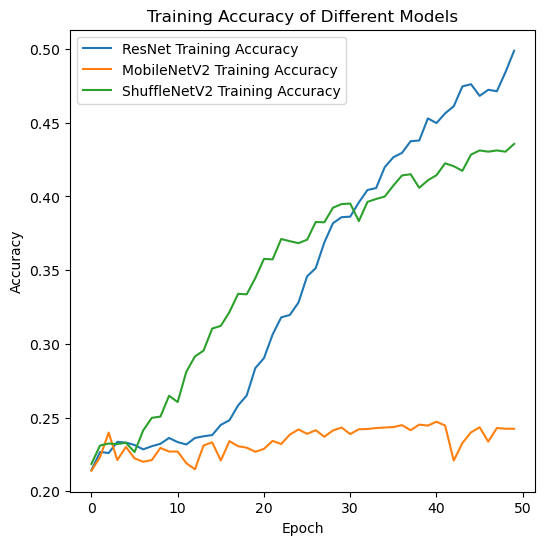

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(train_acc_resnet, label='ResNet Training Accuracy')
#plt.plot(val_acc_resnet, label='ResNet Validation Accuracy')
plt.plot(train_acc_mobilenet, label='MobileNetV2 Training Accuracy')
#plt.plot(val_acc_mobilenet, label='MobileNetV2 Validation Accuracy')
plt.plot(train_acc_shufflenet, label='ShuffleNetV2 Training Accuracy')
#plt.plot(val_acc_shufflenet, label='ShuffleNetV2 Validation Accuracy')
plt.title('Training Accuracy of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

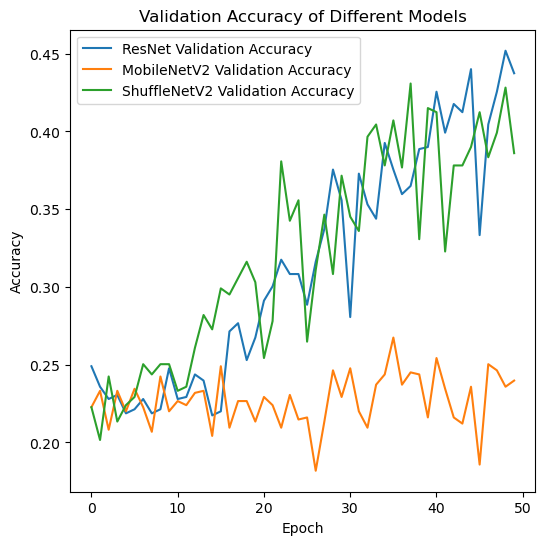

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
#plt.plot(train_acc_resnet, label='ResNet Training Accuracy')
plt.plot(val_acc_resnet, label='ResNet Validation Accuracy')
#plt.plot(train_acc_mobilenet, label='MobileNetV2 Training Accuracy')
plt.plot(val_acc_mobilenet, label='MobileNetV2 Validation Accuracy')
#plt.plot(train_acc_shufflenet, label='ShuffleNetV2 Training Accuracy')
plt.plot(val_acc_shufflenet, label='ShuffleNetV2 Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

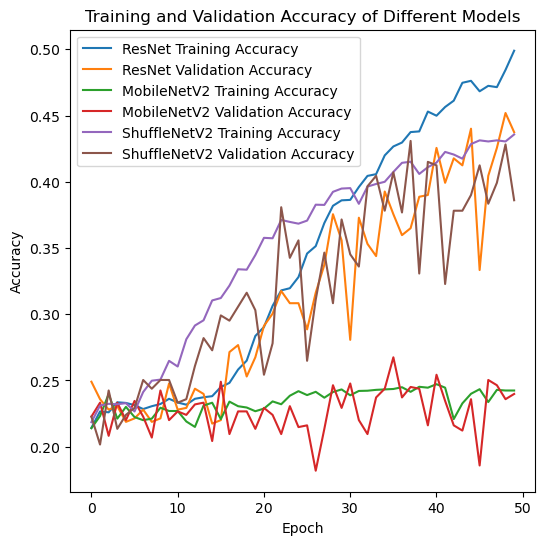

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(train_acc_resnet, label='ResNet Training Accuracy')
plt.plot(val_acc_resnet, label='ResNet Validation Accuracy')
plt.plot(train_acc_mobilenet, label='MobileNetV2 Training Accuracy')
plt.plot(val_acc_mobilenet, label='MobileNetV2 Validation Accuracy')
plt.plot(train_acc_shufflenet, label='ShuffleNetV2 Training Accuracy')
plt.plot(val_acc_shufflenet, label='ShuffleNetV2 Validation Accuracy')
plt.title('Training and Validation Accuracy of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


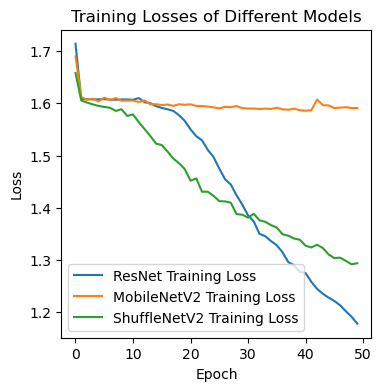

In [12]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss_resnet, label='ResNet Training Loss')
#plt.plot(val_loss_resnet, label='ResNet Validation Loss')
plt.plot(train_loss_mobilenet, label='MobileNetV2 Training Loss')
#plt.plot(val_loss_mobilenet, label='MobileNetV2 Validation Loss')
plt.plot(train_loss_shufflenet, label='ShuffleNetV2 Training Loss')
#plt.plot(val_loss_shufflenet, label='ShuffleNetV2 Validation Loss')
plt.title('Training Losses of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

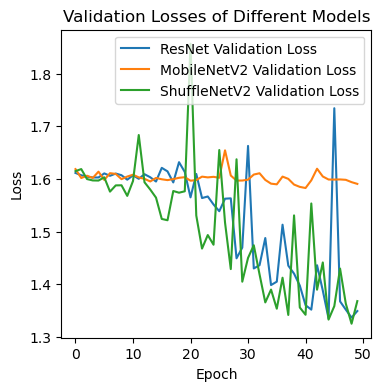

In [13]:
plt.figure(figsize=(4, 4))
#plt.plot(train_loss_resnet, label='ResNet Training Loss')
plt.plot(val_loss_resnet, label='ResNet Validation Loss')
#plt.plot(train_loss_mobilenet, label='MobileNetV2 Training Loss')
plt.plot(val_loss_mobilenet, label='MobileNetV2 Validation Loss')
#plt.plot(train_loss_shufflenet, label='ShuffleNetV2 Training Loss')
plt.plot(val_loss_shufflenet, label='ShuffleNetV2 Validation Loss')
plt.title('Validation Losses of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

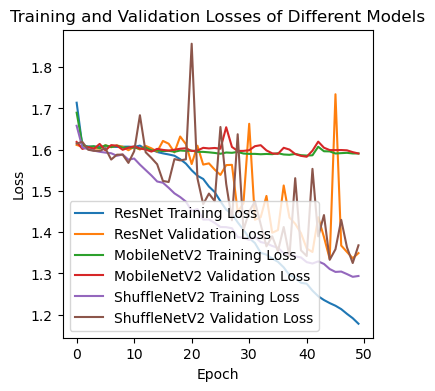

In [14]:

plt.figure(figsize=(4, 4))
plt.plot(train_loss_resnet, label='ResNet Training Loss')
plt.plot(val_loss_resnet, label='ResNet Validation Loss')
plt.plot(train_loss_mobilenet, label='MobileNetV2 Training Loss')
plt.plot(val_loss_mobilenet, label='MobileNetV2 Validation Loss')
plt.plot(train_loss_shufflenet, label='ShuffleNetV2 Training Loss')
plt.plot(val_loss_shufflenet, label='ShuffleNetV2 Validation Loss')
plt.title('Training and Validation Losses of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


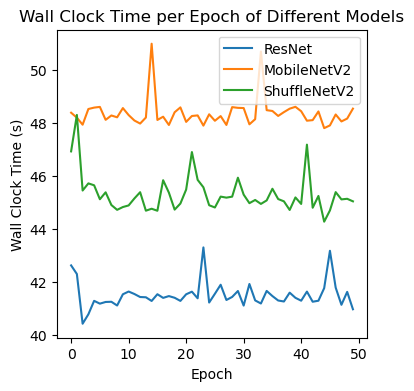

In [15]:
plt.figure(figsize=(4, 4))
plt.plot(epoch_time_resnet, label='ResNet')
plt.plot(epoch_time_mobilenet, label='MobileNetV2')
plt.plot(epoch_time_shufflenet, label='ShuffleNetV2')
plt.title('Wall Clock Time per Epoch of Different Models')
plt.xlabel('Epoch')
plt.ylabel('Wall Clock Time (s)')
plt.legend()
plt.show()

In [16]:
# evaluate the models on the test set
with torch.no_grad():
    # set the models to evaluation mode
    resnet.eval()
    mobilenet.eval()
    shufflenet.eval()

    # define the lists to store the test accuracy values
    test_acc_resnet = []
    test_acc_mobilenet = []
    test_acc_shufflenet = []

    # loop over the test set
    for images, labels in test_loader:
        # move the data to the device
        images, labels = images.to(device), labels.to(device)

        # make predictions using the models
        outputs_resnet = resnet(images)
        outputs_mobilenet = mobilenet(images)
        outputs_shufflenet = shufflenet(images)

        # get the predicted class
        _, predicted_resnet = torch.max(outputs_resnet.data, 1)
        _, predicted_mobilenet = torch.max(outputs_mobilenet.data, 1)
        _, predicted_shufflenet = torch.max(outputs_shufflenet.data, 1)

        # compute the accuracy of the models on the test set
        test_acc_resnet.append((predicted_resnet == labels).sum().item() / labels.size(0))
        test_acc_mobilenet.append((predicted_mobilenet == labels).sum().item() / labels.size(0))
        test_acc_shufflenet.append((predicted_shufflenet == labels).sum().item() / labels.size(0))

# print the test accuracies of the models
print('ResNet Test Accuracy: {:.2f}%'.format(100 * sum(test_acc_resnet) / len(test_acc_resnet)))
print('MobileNetV2 Test Accuracy: {:.2f}%'.format(100 * sum(test_acc_mobilenet) / len(test_acc_mobilenet)))
print('ShuffleNetV2 Test Accuracy: {:.2f}%'.format(100 * sum(test_acc_shufflenet) / len(test_acc_shufflenet)))


ResNet Test Accuracy: 42.86%
MobileNetV2 Test Accuracy: 23.68%
ShuffleNetV2 Test Accuracy: 38.91%


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# set the models to evaluation mode
resnet.eval()
mobilenet.eval()
shufflenet.eval()

# create empty prediction lists for each model
resnet_predictions = []
mobilenet_predictions = []
shufflenet_predictions = []

# make predictions on the test data and store the predicted probabilities
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        resnet_output = resnet(images)
        mobilenet_output = mobilenet(images)
        shufflenet_output = shufflenet(images)
        resnet_predictions.extend(resnet_output.cpu().numpy())
        mobilenet_predictions.extend(mobilenet_output.cpu().numpy())
        shufflenet_predictions.extend(shufflenet_output.cpu().numpy())

# convert the prediction lists to numpy arrays
resnet_prob = np.array(resnet_predictions)
mobilenet_prob = np.array(mobilenet_predictions)
shufflenet_prob = np.array(shufflenet_predictions)

# get the true labels for the test data
y_true = np.array([t for _, t in test_loader.dataset])

# calculate the false positive rate, true positive rate, and AUC for each class and model
n_classes = len(np.unique(y_true))
fpr_resnet = dict()
tpr_resnet = dict()
roc_auc_resnet = dict()
fpr_mobilenet = dict()
tpr_mobilenet = dict()
roc_auc_mobilenet = dict()
fpr_shufflenet = dict()
tpr_shufflenet = dict()
roc_auc_shufflenet = dict()

for i in range(n_classes):
    # calculate the ROC curve and AUC for ResNet
    fpr_resnet[i], tpr_resnet[i], _ = roc_curve(y_true == i, resnet_prob[:, i])
    roc_auc_resnet[i] = auc(fpr_resnet[i], tpr_resnet[i])
    
    # calculate the ROC curve and AUC for MobileNet
    fpr_mobilenet[i], tpr_mobilenet[i], _ = roc_curve(y_true == i, mobilenet_prob[:, i])
    roc_auc_mobilenet[i] = auc(fpr_mobilenet[i], tpr_mobilenet[i])
    
    # calculate the ROC curve and AUC for ShuffleNet
    fpr_shufflenet[i], tpr_shufflenet[i], _ = roc_curve(y_true == i, shufflenet_prob[:, i])
    roc_auc_shufflenet[i] = auc(fpr_shufflenet[i], tpr_shufflenet[i])

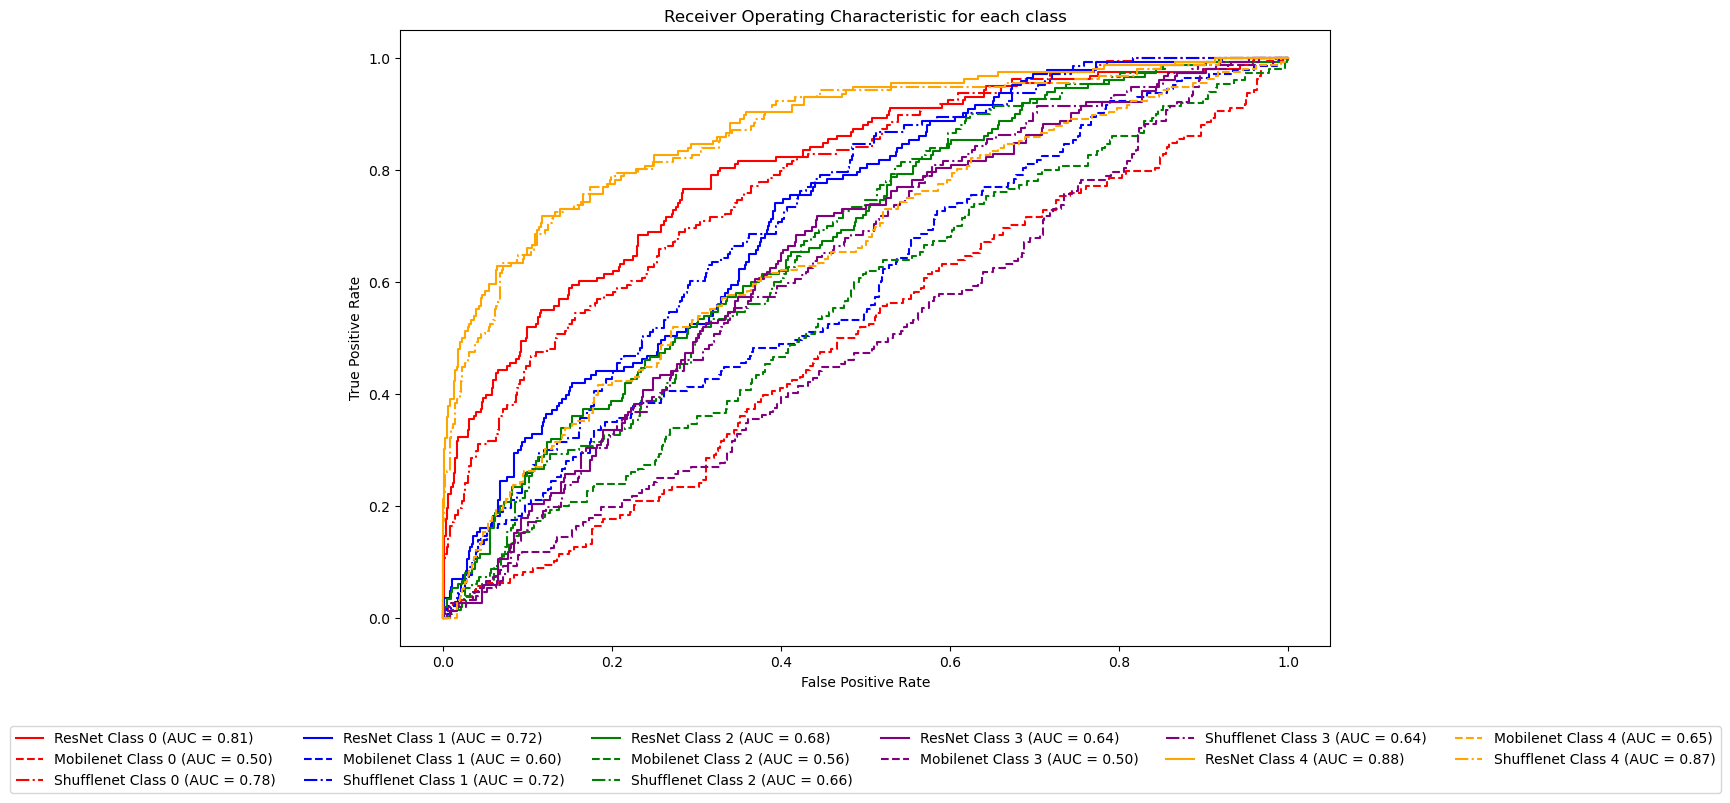

In [18]:
# plot ROC curve for each class and model
plt.figure(figsize=(12,8))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.plot(fpr_resnet[i], tpr_resnet[i], color=colors[i], label=f'ResNet Class {i} (AUC = {roc_auc_resnet[i]:.2f})')
    plt.plot(fpr_mobilenet[i], tpr_mobilenet[i], color=colors[i], label=f'Mobilenet Class {i} (AUC = {roc_auc_mobilenet[i]:.2f})', linestyle='--')
    plt.plot(fpr_shufflenet[i], tpr_shufflenet[i], color=colors[i], label=f'Shufflenet Class {i} (AUC = {roc_auc_shufflenet[i]:.2f})', linestyle='-.')
    

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=6)
plt.show()

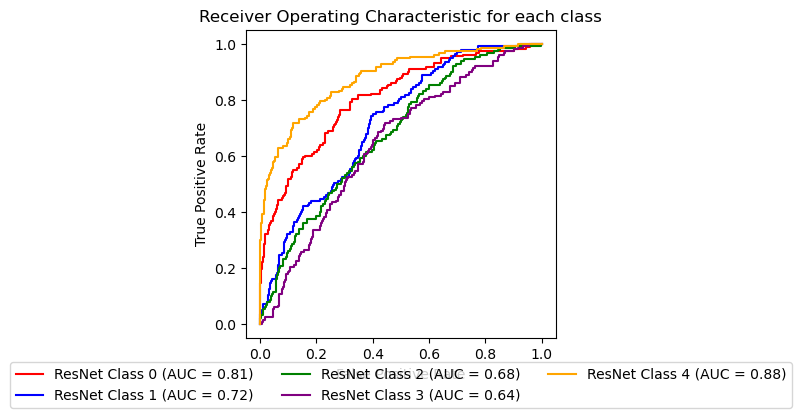

In [30]:
# plot ROC curve for each class and model
plt.figure(figsize=(4,4))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    plt.plot(fpr_resnet[i], tpr_resnet[i], color=colors[i], label=f'ResNet Class {i} (AUC = {roc_auc_resnet[i]:.2f})')
    #plt.plot(fpr_mobilenet[i], tpr_mobilenet[i], color=colors[i], label=f'Mobilenet Class {i} (AUC = {roc_auc_mobilenet[i]:.2f})', linestyle='--')
    #plt.plot(fpr_shufflenet[i], tpr_shufflenet[i], color=colors[i], label=f'Shufflenet Class {i} (AUC = {roc_auc_shufflenet[i]:.2f})', linestyle='-.')
    

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

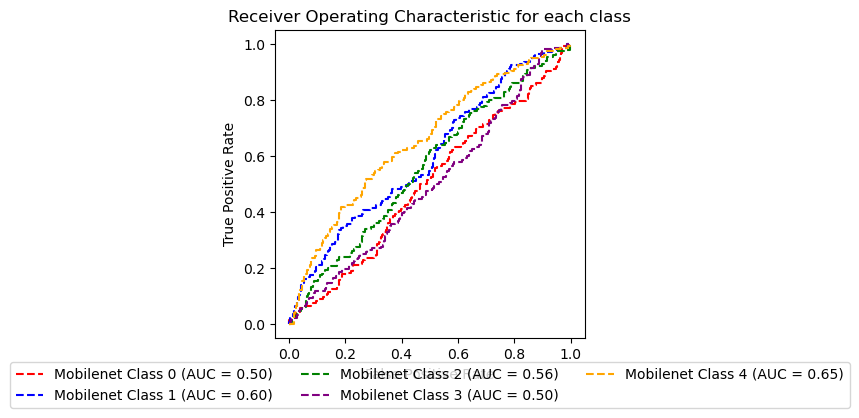

In [29]:
# plot ROC curve for each class and model
plt.figure(figsize=(4,4))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    #plt.plot(fpr_resnet[i], tpr_resnet[i], color=colors[i], label=f'ResNet Class {i} (AUC = {roc_auc_resnet[i]:.2f})')
    plt.plot(fpr_mobilenet[i], tpr_mobilenet[i], color=colors[i], label=f'Mobilenet Class {i} (AUC = {roc_auc_mobilenet[i]:.2f})', linestyle='--')
    #plt.plot(fpr_shufflenet[i], tpr_shufflenet[i], color=colors[i], label=f'Shufflenet Class {i} (AUC = {roc_auc_shufflenet[i]:.2f})', linestyle='-.')
    

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

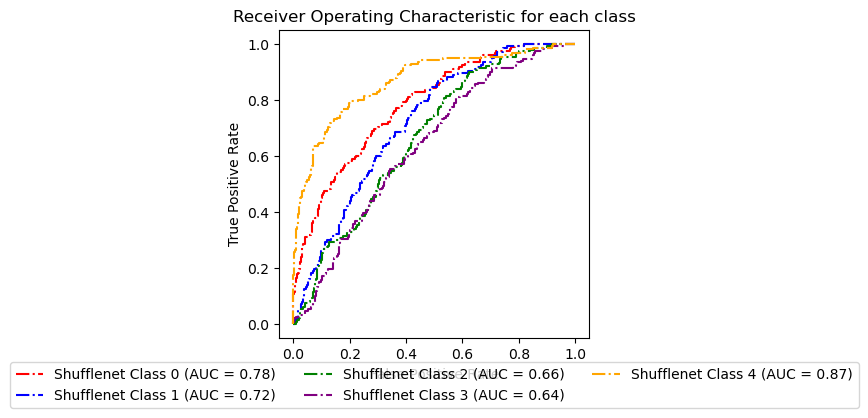

In [28]:
# plot ROC curve for each class and model
plt.figure(figsize=(4,4))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(n_classes):
    #plt.plot(fpr_resnet[i], tpr_resnet[i], color=colors[i], label=f'ResNet Class {i} (AUC = {roc_auc_resnet[i]:.2f})')
    #plt.plot(fpr_mobilenet[i], tpr_mobilenet[i], color=colors[i], label=f'Mobilenet Class {i} (AUC = {roc_auc_mobilenet[i]:.2f})', linestyle='--')
    plt.plot(fpr_shufflenet[i], tpr_shufflenet[i], color=colors[i], label=f'Shufflenet Class {i} (AUC = {roc_auc_shufflenet[i]:.2f})', linestyle='-.')
    

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

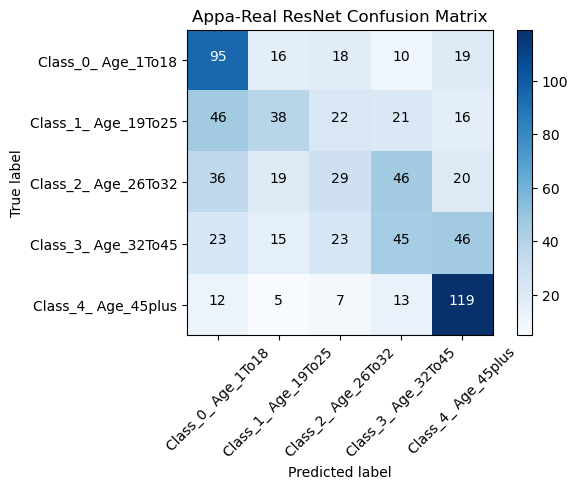

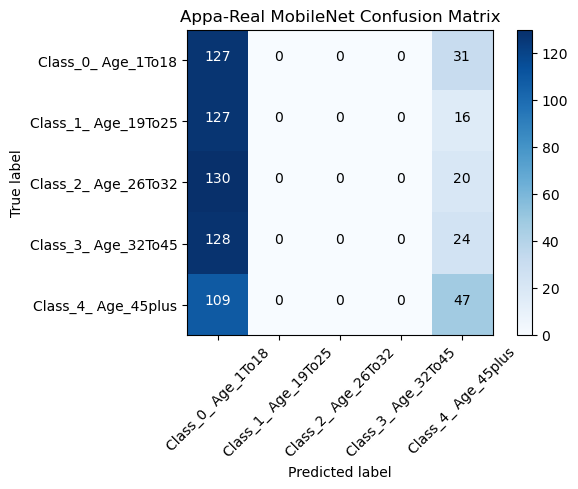

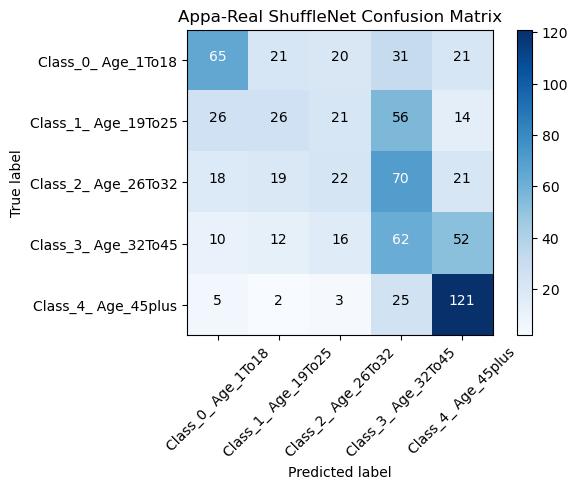

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# evaluate the models on the test set
resnet.eval()
mobilenet.eval()
shufflenet.eval()

# initialize the confusion matrix for each model
cm_resnet = np.zeros((5, 5))
cm_mobilenet = np.zeros((5, 5))
cm_shufflenet = np.zeros((5, 5))

test_labels = []
resnet_preds = []
mobilenet_preds = []
shufflenet_preds = []

# make predictions on the test set and update the confusion matrix
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        cm_resnet += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(5))
        test_labels.extend(labels.cpu().numpy())
        resnet_preds.extend(predicted.cpu().numpy())
        
        
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mobilenet(inputs)
        _, predicted = torch.max(outputs, 1)
        cm_mobilenet += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(5))
        mobilenet_preds.extend(predicted.cpu().numpy())
        
        
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = shufflenet(inputs)
        _, predicted = torch.max(outputs, 1)
        cm_shufflenet += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy(), labels=range(5))
        shufflenet_preds.extend(predicted.cpu().numpy())
        
        

# define the class names
classes = ['Class_0_ Age_1To18', 'Class_1_ Age_19To25', 'Class_2_ Age_26To32', 'Class_3_ Age_32To45', 'Class_4_ Age_45plus']

# plot the confusion matrix for each model
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'  # Use '%f' instead of '%d' for floating-point numbers
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrices separately for each model
plot_confusion_matrix(cm_resnet, classes, 'Appa-Real ResNet Confusion Matrix')
plt.show()

plot_confusion_matrix(cm_mobilenet, classes, 'Appa-Real MobileNet Confusion Matrix')
plt.show()

plot_confusion_matrix(cm_shufflenet, classes, 'Appa-Real ShuffleNet Confusion Matrix')
plt.show()

In [32]:
# print the classification report for each model
print('Appa-Real ResNet Classification Report')
print(classification_report(test_labels, resnet_preds, target_names=classes))

print('Appa-Real MobileNet Classification Report')
print(classification_report(test_labels, mobilenet_preds, target_names=classes))

print('Appa-Real Shufflenet Classification Report')
print(classification_report(test_labels, shufflenet_preds, target_names=classes))

Appa-Real ResNet Classification Report
                     precision    recall  f1-score   support

 Class_0_ Age_1To18       0.45      0.60      0.51       158
Class_1_ Age_19To25       0.41      0.27      0.32       143
Class_2_ Age_26To32       0.29      0.19      0.23       150
Class_3_ Age_32To45       0.33      0.30      0.31       152
Class_4_ Age_45plus       0.54      0.76      0.63       156

           accuracy                           0.43       759
          macro avg       0.40      0.42      0.40       759
       weighted avg       0.41      0.43      0.41       759

Appa-Real MobileNet Classification Report
                     precision    recall  f1-score   support

 Class_0_ Age_1To18       0.20      0.80      0.33       158
Class_1_ Age_19To25       0.00      0.00      0.00       143
Class_2_ Age_26To32       0.00      0.00      0.00       150
Class_3_ Age_32To45       0.00      0.00      0.00       152
Class_4_ Age_45plus       0.34      0.30      0.32       156


C:\Users\krish\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\krish\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\krish\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# Save the models
torch.save(resnet.state_dict(), "Appa-Real_resnet.pth")
torch.save(mobilenet.state_dict(), "Appa-Real_mobilenet.pth")
torch.save(shufflenet.state_dict(), "Appa-Real_shufflenet.pth")